# Predicting the severity of Road accident based on Traffic Incident data
### Data Retrived from- City of Seattle at the open data platform (https://data.seattle.gov)
#### Data And Meta Data Links- 
##### Meta Data- https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf.
##### Data- http://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0/data
We are trying to create a model to predict the accident severity by road and weather conditions so that the Drivers may act accordingly to the warnings provided. Our goal is to create a machine learning model so that we can predict that under certain given weather or road conditions how severe is the accident which has the possibility of occurring.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import sklearn
from sklearn import preprocessing
from collections import Counter
import matplotlib.pyplot as plt
import time

In [2]:
df=pd.read_csv('https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv')

In [3]:
#View All column names of data set
pd.options.display.max_columns = None
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.356511,47.517361,1,327920,329420,3856094,Matched,Intersection,34911.0,17TH AVE SW AND SW ROXBURY ST,,NaN,1,Property Damage Only Collision,Angles,2,0,0,2,0,0,0,2020/01/19 00:00:00+00,1/19/2020 9:01:00 AM,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.361405,47.702064,2,46200,46200,1791736,Matched,Block,NaN,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,NaN,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,0,0,0,2005/04/11 00:00:00+00,4/11/2005 6:31:00 PM,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",Y,0,Raining,Wet,Dusk,NaN,5101020.0,NaN,13,From same direction - both going straight - bo...,0,0,N
2,-122.317414,47.664028,3,1212,1212,3507861,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,,NaN,2,Injury Collision,Head On,2,0,0,2,1,0,0,2013/03/31 00:00:00+00,3/31/2013 2:09:00 AM,Mid-Block (not related to intersection),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Dark - Street Lights On,NaN,NaN,NaN,30,From opposite direction - all others,0,0,N
3,-122.318234,47.619927,4,327909,329409,EA03026,Matched,Intersection,29054.0,11TH AVE E AND E JOHN ST,,NaN,2,Injury Collision,Pedestrian,3,1,0,1,1,0,0,2020/01/06 00:00:00+00,1/6/2020 5:55:00 PM,At Intersection (intersection related),24.0,MOTOR VEHCILE STRUCK PEDESTRIAN,NaN,N,Raining,Wet,Dark - Street Lights On,NaN,NaN,NaN,0,Vehicle going straight hits pedestrian,0,0,N
4,-122.351724,47.560306,5,104900,104900,2671936,Matched,Block,NaN,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,NaN,NaN,2,Injury Collision,Other,2,0,0,1,1,0,0,2009/12/25 00:00:00+00,12/25/2009 7:00:00 PM,Mid-Block (not related to intersection),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,0,Clear,Ice,Dark - Street Lights On,NaN,9359012.0,Y,50,Fixed object,0,0,N


In [4]:
#dropping unknown Severity code because it would not be helpful in prediction
df.SEVERITYCODE.value_counts()

1     137776
2      58842
0      21656
2b      3111
3        352
Name: SEVERITYCODE, dtype: int64

In [5]:
df.drop(df[df["SEVERITYCODE"]=='0'].index,axis=0,inplace=True)
df.SEVERITYCODE.value_counts()

1     137776
2      58842
2b      3111
3        352
Name: SEVERITYCODE, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200082 entries, 0 to 221737
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                194673 non-null  float64
 1   Y                194673 non-null  float64
 2   OBJECTID         200082 non-null  int64  
 3   INCKEY           200082 non-null  int64  
 4   COLDETKEY        200082 non-null  int64  
 5   REPORTNO         200082 non-null  object 
 6   STATUS           200082 non-null  object 
 7   ADDRTYPE         198149 non-null  object 
 8   INTKEY           67533 non-null   float64
 9   LOCATION         197385 non-null  object 
 10  EXCEPTRSNCODE    88453 non-null   object 
 11  EXCEPTRSNDESC    5686 non-null    object 
 12  SEVERITYCODE     200081 non-null  object 
 13  SEVERITYDESC     200082 non-null  object 
 14  COLLISIONTYPE    195285 non-null  object 
 15  PERSONCOUNT      200082 non-null  int64  
 16  PEDCOUNT         200082 non-null  int6

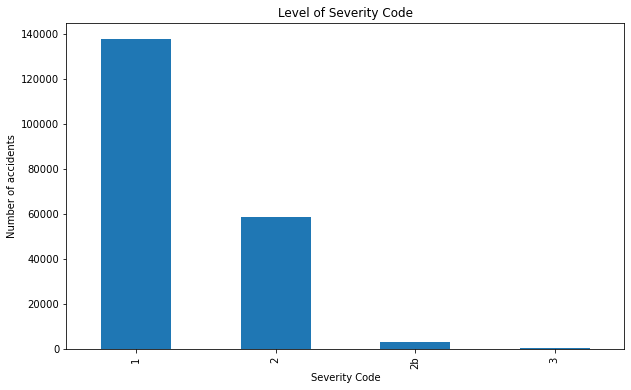

In [7]:
#let us visuaize the imbalance in data
df['SEVERITYCODE'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Severity Code') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Level of Severity Code') # add title to the plot

plt.show()

#### As we can see that the data is highly imbalanced towards prop damage
Since 2b and 3 are far too less in comparision to other let's Club them together to create a new class 2
**Class 1- Prop Damage Class 2- Human Damage**
We would try to reduce the imbalance by randomly selectng SEVERITYCODE == 1 and making it equal to 2

In [8]:
# Club 2b and 3 in the same class 2
df.SEVERITYCODE.replace('2b','2',inplace=True)
df.SEVERITYCODE.replace('3','2',inplace=True)
df.SEVERITYCODE.value_counts()

1    137776
2     62305
Name: SEVERITYCODE, dtype: int64

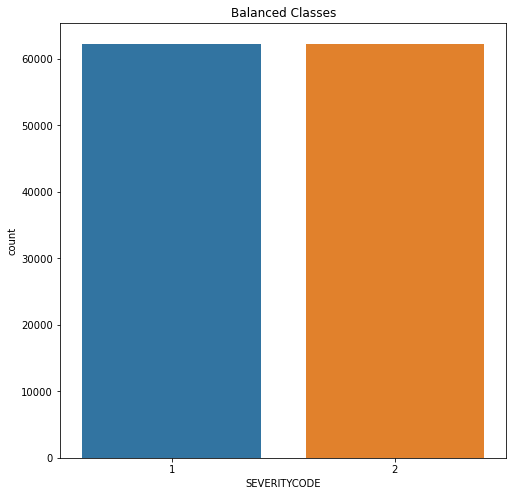

In [9]:
import seaborn as sns
# Shuffle the Dataset.
shuffled_df = df.sample(frac=1,random_state=4)
# Put all the classes other than with SEVERITYCODE '1' in a separate dataset.
normal_df = shuffled_df.loc[shuffled_df['SEVERITYCODE'] == '2']

#Randomly select 58842 observations from the non-fraud (majority class)
biased_df = shuffled_df.loc[shuffled_df['SEVERITYCODE'] == '1'].sample(n=62305,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([normal_df, biased_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('SEVERITYCODE', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [10]:
normalized_df.SEVERITYCODE.value_counts()

1    62305
2    62305
Name: SEVERITYCODE, dtype: int64

### Exploratory Data Analysis

In [11]:
dfA=normalized_df[['WEATHER','ADDRTYPE','JUNCTIONTYPE','ROADCOND','LIGHTCOND','SEVERITYCODE','SPEEDING','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','SERIOUSINJURIES','FATALITIES','INCDATE','INCDTTM','INATTENTIONIND','UNDERINFL']]

In [12]:
dfA.head()

,WEATHER,ADDRTYPE,JUNCTIONTYPE,ROADCOND,LIGHTCOND,SEVERITYCODE,SPEEDING,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,INATTENTIONIND,UNDERINFL
142228,Clear,Block,Mid-Block (not related to intersection),Dry,Daylight,2,NaN,5,0,0,2,0,0,2014/02/03 00:00:00+00,2/3/2014 1:46:00 PM,NaN,N
112455,Raining,Block,Mid-Block (but intersection related),Wet,Dark - Street Lights On,2,NaN,2,1,0,1,0,0,2011/12/27 00:00:00+00,12/27/2011 4:43:00 PM,NaN,N
26660,Clear,Block,Mid-Block (not related to intersection),Dry,Daylight,2,NaN,3,0,0,2,0,1,2005/06/04 00:00:00+00,6/4/2005,NaN,1
156758,Clear,Block,NaN,Dry,Daylight,2,NaN,2,1,0,1,0,0,2015/03/09 00:00:00+00,3/9/2015 4:23:00 PM,NaN,N
199920,Clear,Intersection,At Intersection (intersection related),Dry,Daylight,2,NaN,2,0,0,2,0,0,2018/09/04 00:00:00+00,9/4/2018 1:58:00 PM,NaN,N


In [13]:
fig=plt.figure()

<Figure size 432x288 with 0 Axes>

#### Plotting Serious Injuries and Fatlities with respect to weather

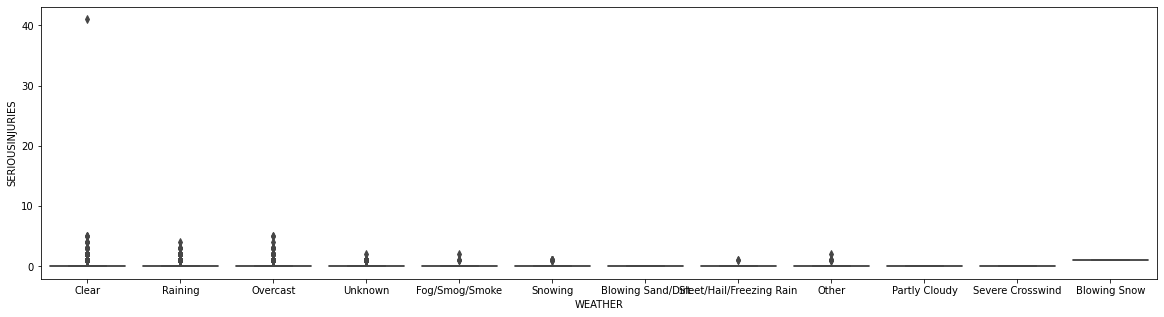

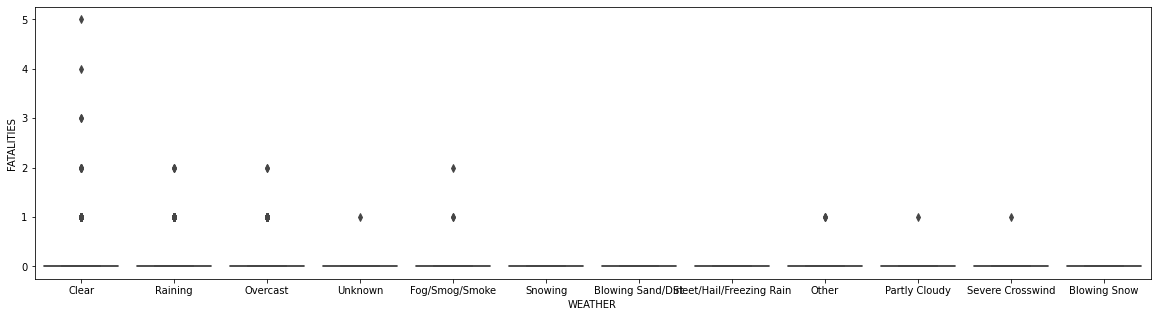

In [14]:
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,1) 
sns.boxplot(data=dfA,x="WEATHER",y="SERIOUSINJURIES")
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,2) 
sns.boxplot(data=dfA,x="WEATHER",y="FATALITIES")

#### Plotting Srious Injury and Fatalities with repect to Road Condition, Light Condition and Junction, Address Type

<ipython-input-15-0cef0a952dbc>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,1)
<ipython-input-15-0cef0a952dbc>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,2)


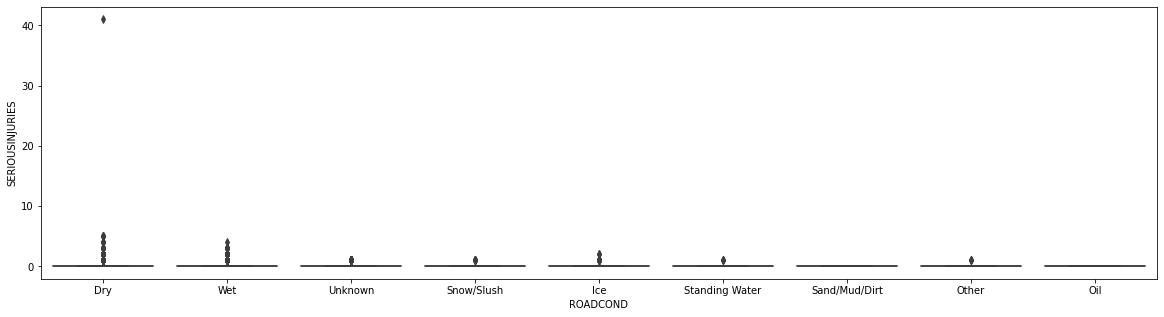

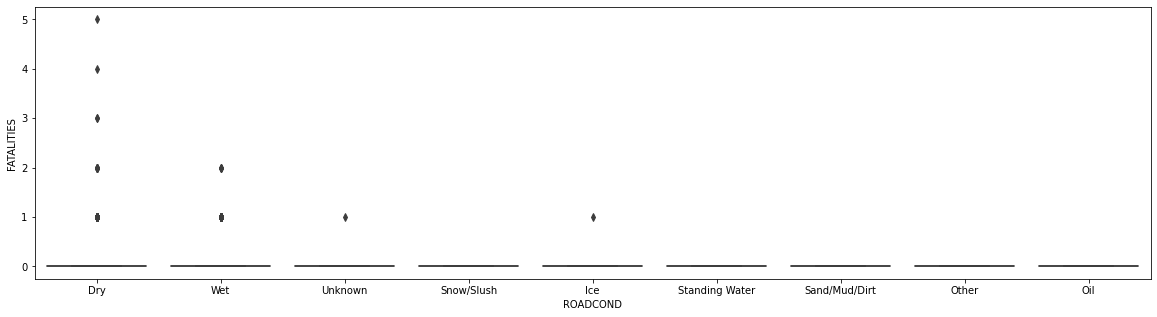

In [15]:
#Road Condition
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,1) 
sns.boxplot(data=dfA,x="ROADCOND",y="SERIOUSINJURIES")
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,2) 
sns.boxplot(data=dfA,x="ROADCOND",y="FATALITIES")

<ipython-input-16-2af0162c4261>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,1)
<ipython-input-16-2af0162c4261>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,2)


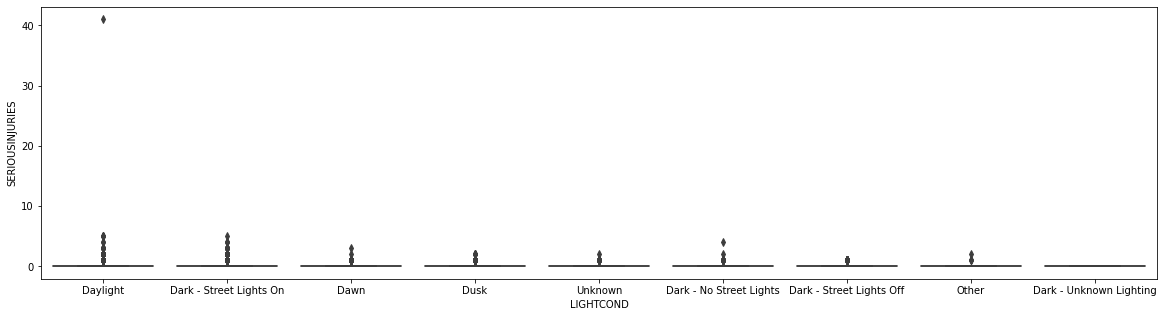

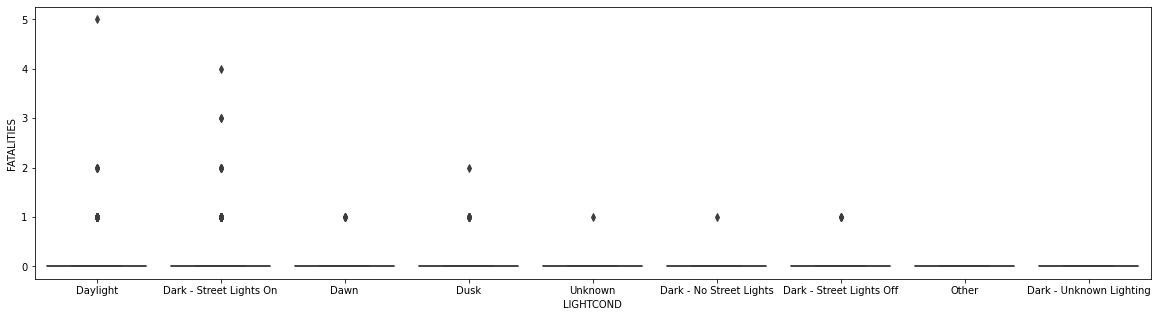

In [16]:
#Light Condition
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,1) 
sns.boxplot(data=dfA,x="LIGHTCOND",y="SERIOUSINJURIES")
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,2) 
sns.boxplot(data=dfA,x="LIGHTCOND",y="FATALITIES")

<ipython-input-17-cdff0036ba85>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,1)
<ipython-input-17-cdff0036ba85>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,2)


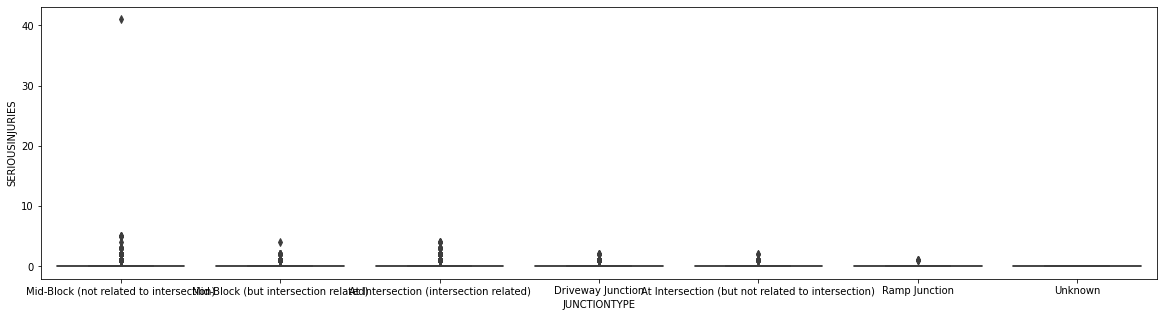

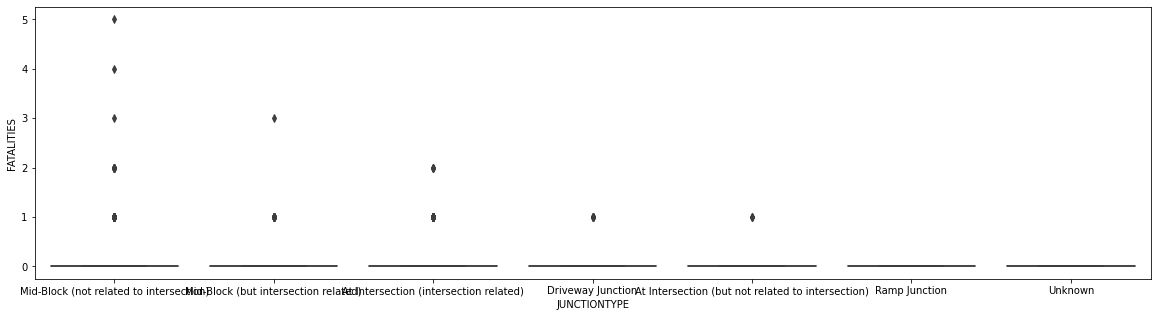

In [17]:
#Junction Type
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,1) 
sns.boxplot(data=dfA,x="JUNCTIONTYPE",y="SERIOUSINJURIES")
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,2) 
sns.boxplot(data=dfA,x="JUNCTIONTYPE",y="FATALITIES")

<ipython-input-18-91ddd3a9fd5a>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,1)
<ipython-input-18-91ddd3a9fd5a>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(2,1,2)


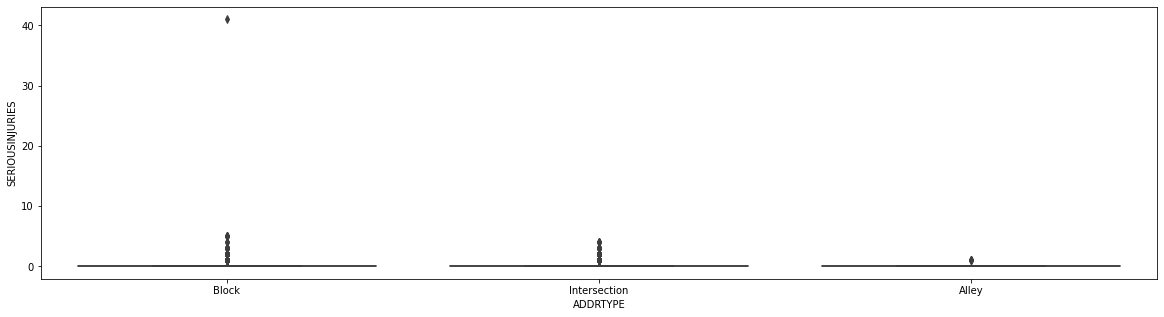

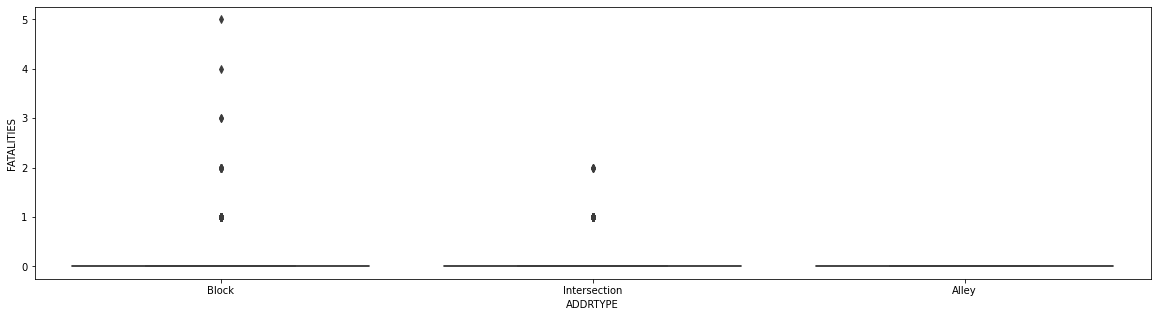

In [18]:
#Address Type
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,1) 
sns.boxplot(data=dfA,x="ADDRTYPE",y="SERIOUSINJURIES")
plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2,1,2) 
sns.boxplot(data=dfA,x="ADDRTYPE",y="FATALITIES")

### Selecting Features
We are Choosing Weather,Road Condition, Light Condition, Junction Type and address type as our variables
So we Visualize and Clean these features.
We are choosing these Features based on the logic that ***only these are the features that will be known to us when our model is ultimatley used to predict the Severity Code Based on data***.
We can create a model based on the weather and road conditions and used the Addresstype and Junction type to tell the driver that these conditions might originate based on where he is.
We are assuming that based on the traffic cams and general traffic pattern we can predict that what would be the ***Count of people and Vehices involved*** so we are adding is to our feature set.

In [19]:
dfK=normalized_df[['WEATHER','ADDRTYPE','JUNCTIONTYPE','ROADCOND','LIGHTCOND','SEVERITYCODE','SPEEDING','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT',]]

#### Speeding

In [20]:
# Repalcing NaN to N
dfK.SPEEDING.replace({np.nan:'N'},inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


#### Weather

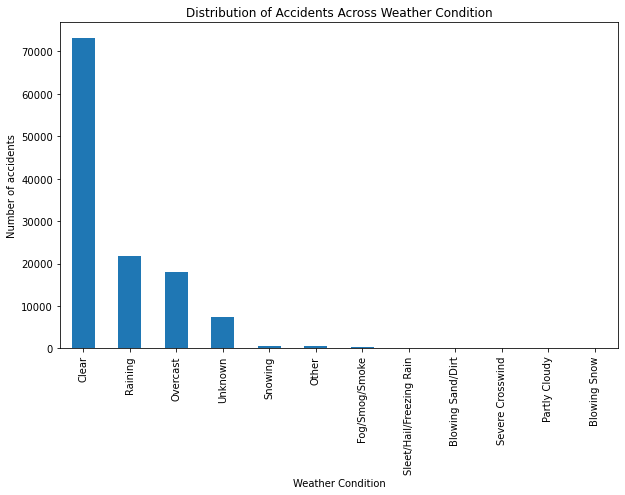

In [21]:
dfK['WEATHER'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Weather Condition') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Distribution of Accidents Across Weather Condition') # add title to the plot

plt.show()

In [22]:
dfK['WEATHER'].value_counts().to_frame()

,WEATHER
Clear,73176
Raining,21886
Overcast,17984
Unknown,7315
Snowing,498
Other,458
Fog/Smog/Smoke,364
Sleet/Hail/Freezing Rain,73
Blowing Sand/Dirt,30
Severe Crosswind,15


In [23]:
#dropping the values that are Unknown and too less in numbers
dfK.drop(dfK[dfK['WEATHER']=='Unknown'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['WEATHER']=='Blowing Snow'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['WEATHER']=='Partly Cloudy'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['WEATHER']=='Severe Crosswind'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['WEATHER']=='Blowing Sand/Dirt'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['WEATHER']=='Sleet/Hail/Freezing Rain'].index,axis=0,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
dfK.WEATHER.value_counts()

Clear             73176
Raining           21886
Overcast          17984
Snowing             498
Other               458
Fog/Smog/Smoke      364
Name: WEATHER, dtype: int64

#### Road Conditions

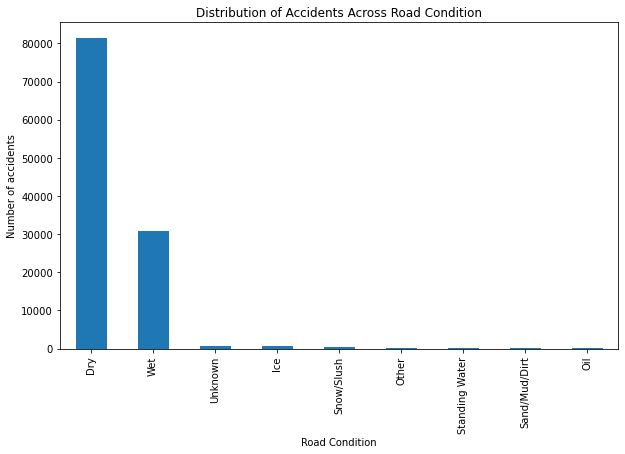

In [25]:
dfK['ROADCOND'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Road Condition') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Distribution of Accidents Across Road Condition') # add title to the plot

plt.show()

In [26]:
dfK.ROADCOND.value_counts().to_frame()

,ROADCOND
Dry,81427
Wet,30875
Unknown,754
Ice,653
Snow/Slush,488
Other,72
Standing Water,69
Sand/Mud/Dirt,48
Oil,40


In [27]:
#drapping Unknown and values with significantly less frequencies
dfK.drop(dfK[dfK['ROADCOND']=='Unknown'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['ROADCOND']=='Oil'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['ROADCOND']=='Sand/Mud/Dirt'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['ROADCOND']=='Standing Water'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['ROADCOND']=='Other'].index,axis=0,inplace=True)
dfK.ROADCOND.value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Dry           81427
Wet           30875
Ice             653
Snow/Slush      488
Name: ROADCOND, dtype: int64

#### Light Conditions

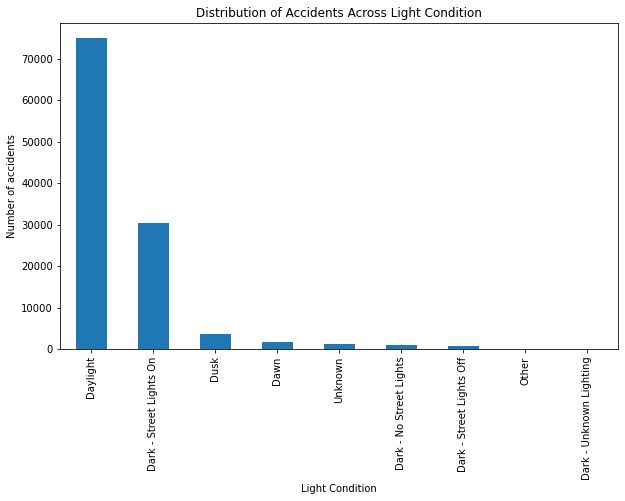

In [28]:
dfK['LIGHTCOND'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Light Condition') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Distribution of Accidents Across Light Condition') # add title to the plot

plt.show()

In [29]:
#drapping Unknown and values with significantly less frequencies
dfK.drop(dfK[dfK['LIGHTCOND']=='Dark - Unknown Lighting'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['LIGHTCOND']=='Other'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['LIGHTCOND']=='Unknown'].index,axis=0,inplace=True)
dfK.LIGHTCOND.value_counts()

Daylight                    74851
Dark - Street Lights On     30280
Dusk                         3710
Dawn                         1628
Dark - No Street Lights       882
Dark - Street Lights Off      711
Name: LIGHTCOND, dtype: int64

#### Address type

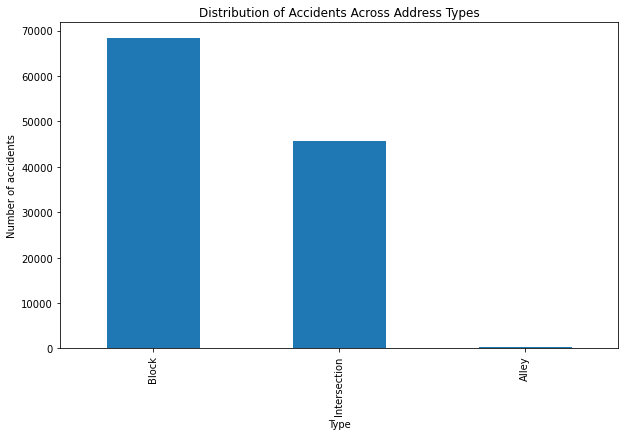

In [30]:
dfK['ADDRTYPE'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Type') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Distribution of Accidents Across Address Types') # add title to the plot

plt.show()

#### Junction Type

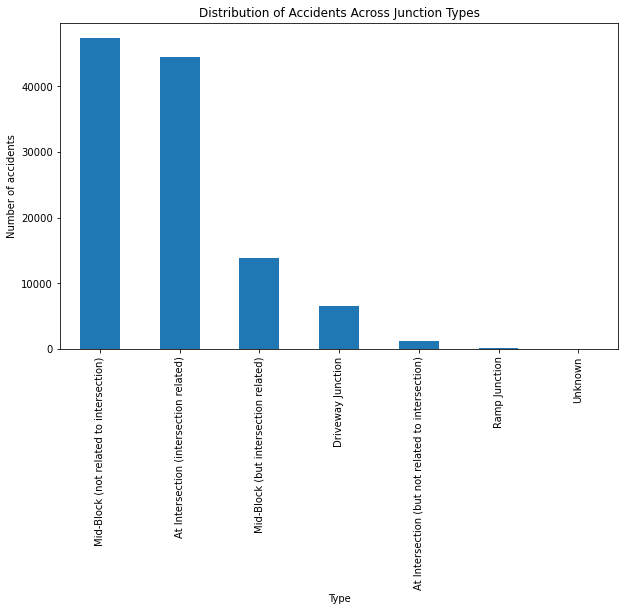

In [31]:
dfK['JUNCTIONTYPE'].value_counts().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Type') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Distribution of Accidents Across Junction Types') # add title to the plot

plt.show()

In [32]:
dfK.JUNCTIONTYPE.value_counts().to_frame()

,JUNCTIONTYPE
Mid-Block (not related to intersection),47316
At Intersection (intersection related),44437
Mid-Block (but intersection related),13850
Driveway Junction,6528
At Intersection (but not related to intersection),1189
Ramp Junction,107
Unknown,6


In [33]:
#dropping Values
dfK.drop(dfK[dfK['JUNCTIONTYPE']=='Ramp Junction'].index,axis=0,inplace=True)
dfK.drop(dfK[dfK['JUNCTIONTYPE']=='Unknown'].index,axis=0,inplace=True)
dfK.JUNCTIONTYPE.value_counts().to_frame()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,JUNCTIONTYPE
Mid-Block (not related to intersection),47316
At Intersection (intersection related),44437
Mid-Block (but intersection related),13850
Driveway Junction,6528
At Intersection (but not related to intersection),1189


In [34]:
#Final DataFrame shape
dfK.describe(include='all')

,WEATHER,ADDRTYPE,JUNCTIONTYPE,ROADCOND,LIGHTCOND,SEVERITYCODE,SPEEDING,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
count,111971,114316,113320,112032,111954,114766,114766,114766.000000,114766.000000,114766.000000,114766.000000
unique,6,3,5,4,6,2,2,NaN,NaN,NaN,NaN
top,Clear,Block,Mid-Block (not related to intersection),Dry,Daylight,2,N,NaN,NaN,NaN,NaN
freq,71934,68316,47316,80443,74779,60731,108308,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.554441,0.067398,0.048098,1.896067
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.447420,0.265202,0.216041,0.690774
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,0.000000,2.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,0.000000,2.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,0.000000,2.000000


#### Cleaning and dropping empty values and NaN values

In [35]:
dfK=dfK.dropna()
dfK.describe(include='all')

,WEATHER,ADDRTYPE,JUNCTIONTYPE,ROADCOND,LIGHTCOND,SEVERITYCODE,SPEEDING,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
count,110409,110409,110409,110409,110409,110409,110409,110409.000000,110409.000000,110409.000000,110409.000000
unique,6,3,5,4,6,2,2,NaN,NaN,NaN,NaN
top,Clear,Block,Mid-Block (not related to intersection),Dry,Daylight,2,N,NaN,NaN,NaN,NaN
freq,70921,65650,45705,79251,73826,59230,104037,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.578694,0.069179,0.049543,1.943139
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.460127,0.268568,0.219036,0.633699
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,0.000000,2.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,0.000000,2.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,0.000000,2.000000


#### Visualizing the effects of various featues on Sevrity Codes

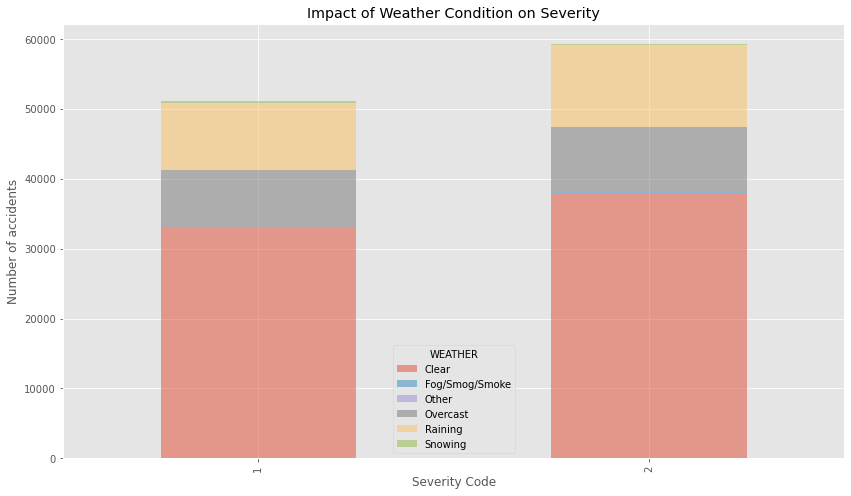

In [36]:
matplotlib.style.use(['ggplot'])
dfK.groupby(['SEVERITYCODE','WEATHER']).size().unstack().plot(kind='bar',stacked=True,figsize=(14, 8),alpha=0.5)
plt.xlabel('Severity Code') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Impact of Weather Condition on Severity') # add title to the plot
plt.show()

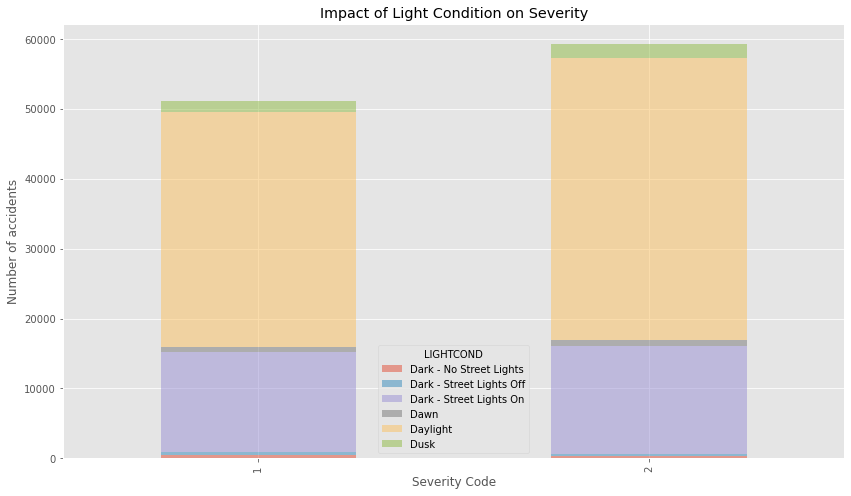

In [37]:
matplotlib.style.use(['ggplot'])
dfK.groupby(['SEVERITYCODE','LIGHTCOND']).size().unstack().plot(kind='bar',stacked=True,figsize=(14, 8),alpha=0.5)
plt.xlabel('Severity Code') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Impact of Light Condition on Severity') # add title to the plot
plt.show()

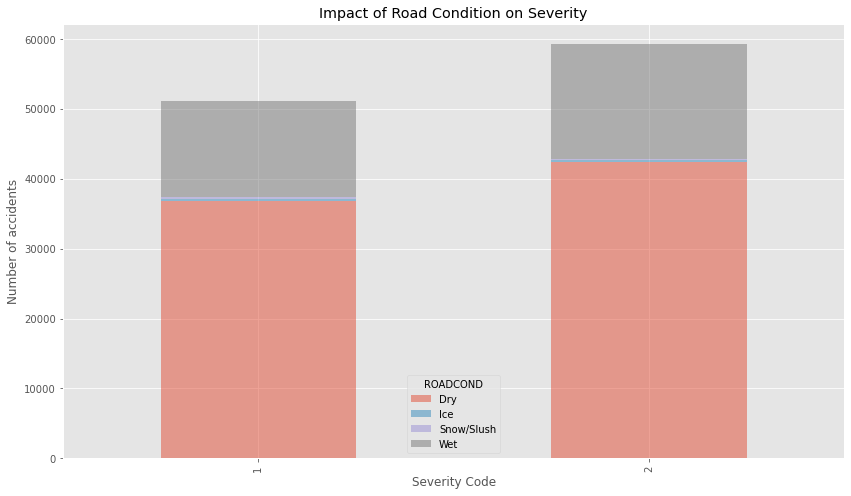

In [38]:
matplotlib.style.use(['ggplot'])
dfK.groupby(['SEVERITYCODE','ROADCOND']).size().unstack().plot(kind='bar',stacked=True,figsize=(14, 8),alpha=0.5)
plt.xlabel('Severity Code') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Impact of Road Condition on Severity') # add title to the plot
plt.show()

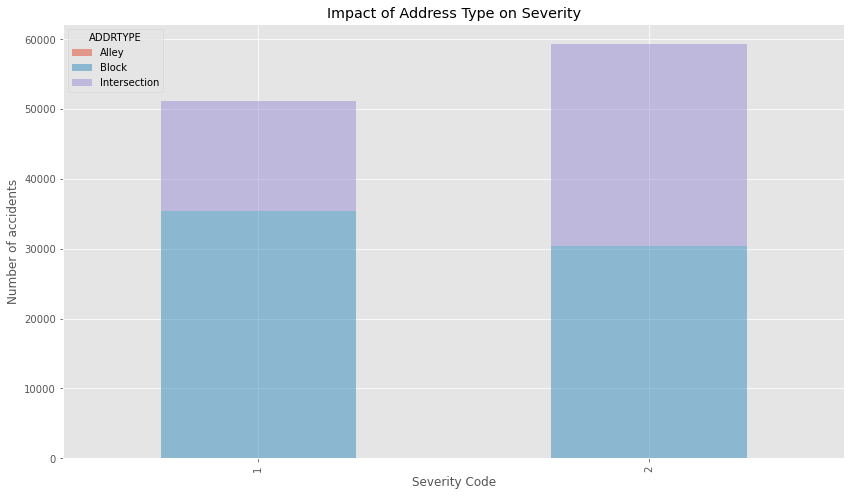

In [39]:
matplotlib.style.use(['ggplot'])
dfK.groupby(['SEVERITYCODE','ADDRTYPE']).size().unstack().plot(kind='bar',stacked=True,figsize=(14, 8),alpha=0.5)
plt.xlabel('Severity Code') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Impact of Address Type on Severity') # add title to the plot
plt.show()

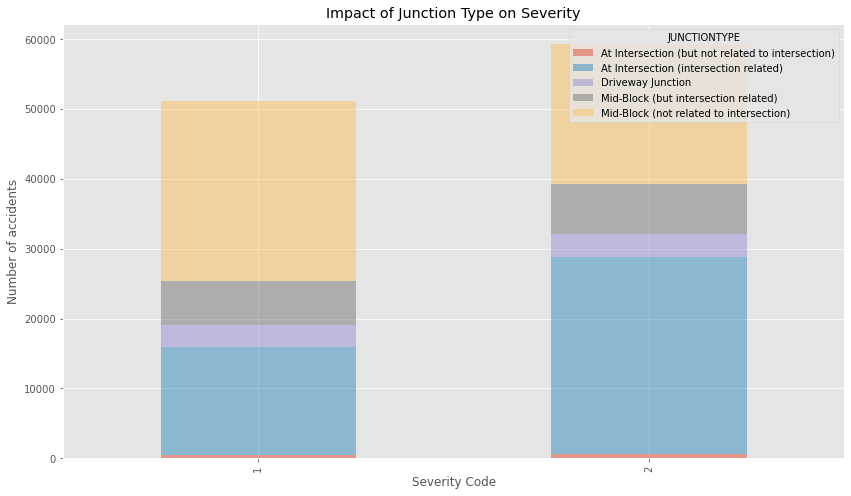

In [40]:
matplotlib.style.use(['ggplot'])
dfK.groupby(['SEVERITYCODE','JUNCTIONTYPE']).size().unstack().plot(kind='bar',stacked=True,figsize=(14, 8),alpha=0.5)
plt.xlabel('Severity Code') # add to x-label to the plot
plt.ylabel('Number of accidents') # add y-label to the plot
plt.title('Impact of Junction Type on Severity') # add title to the plot
plt.show()

### ONE HOT ENCODING of the Data

In [41]:
#Weather
dfn=pd.get_dummies(dfK['WEATHER'])
dfK= pd.concat([dfK,dfn], axis=1)
dfK.drop(['WEATHER'], axis = 1,inplace=True)
# Road Conditions
dfn=pd.get_dummies(dfK['ROADCOND'])
dfK= pd.concat([dfK,dfn], axis=1)
dfK.drop(['ROADCOND'], axis = 1,inplace=True)
#Light Conditions
dfn=pd.get_dummies(dfK['LIGHTCOND'])
dfK= pd.concat([dfK,dfn], axis=1)
dfK.drop(['LIGHTCOND'], axis = 1,inplace=True)
#Junction Type
dfn=pd.get_dummies(dfK['JUNCTIONTYPE'])
dfK= pd.concat([dfK,dfn], axis=1)
dfK.drop(['JUNCTIONTYPE'], axis = 1,inplace=True)
#Address Type
dfn=pd.get_dummies(dfK['ADDRTYPE'])
dfK= pd.concat([dfK,dfn], axis=1)
dfK.drop(['ADDRTYPE'], axis = 1,inplace=True)
#Speeding
dfn=pd.get_dummies(dfK['SPEEDING'])
dfK= pd.concat([dfK,dfn], axis=1)
dfK.drop(['SPEEDING'], axis = 1,inplace=True)
dfK.describe()

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,Clear,Fog/Smog/Smoke,Other,Overcast,Raining,Snowing,Dry,Ice,Snow/Slush,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dawn,Daylight,Dusk,At Intersection (but not related to intersection),At Intersection (intersection related),Driveway Junction,Mid-Block (but intersection related),Mid-Block (not related to intersection),Alley,Block,Intersection,N,Y
count,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.00000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000,110409.000000
mean,2.578694,0.069179,0.049543,1.943139,0.642348,0.003098,0.001413,0.156853,0.192185,0.004103,0.717795,0.005597,0.004076,0.272532,0.007708,0.006322,0.269752,0.01451,0.668659,0.033050,0.010515,0.393935,0.058410,0.123178,0.413961,0.000933,0.594607,0.404460,0.942287,0.057713
std,1.460127,0.268568,0.219036,0.633699,0.479311,0.055570,0.037563,0.363664,0.394020,0.063923,0.450075,0.074606,0.063712,0.445264,0.087455,0.079259,0.443833,0.11958,0.470697,0.178768,0.102005,0.488623,0.234518,0.328643,0.492544,0.030529,0.490970,0.490789,0.233200,0.233200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,93.000000,6.000000,2.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Creating Feature Set and Target Variable

In [42]:
X=dfK.loc[:, dfK.columns != 'SEVERITYCODE'].values
y=dfK['SEVERITYCODE'].values

#### Test Train Split

In [43]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (77286, 30) (77286,)
Test set: (33123, 30) (33123,)


# Classification
## Why classification?
### Since the target value is not continious and we are to divide the prediction among the four given severity codes classification is the best choice to build a machine learning model

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#Selcting the best C value for logistic regression
start = time.time()
c_val=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
for i in c_val:
    LR = LogisticRegression(C=i, solver='liblinear').fit(x_train,y_train)
    yhat = LR.predict(x_test)
    print('Accuracy score for C value ',i,':',accuracy_score(y_test,yhat))
end = time.time()
print("total Time Elasped: ",end - start," seconds")

Accuracy score for C value  1e-05 : 0.5370588412885307
Accuracy score for C value  0.0001 : 0.6427859795308396
Accuracy score for C value  0.001 : 0.6414877879419135
Accuracy score for C value  0.01 : 0.6437822660990852
Accuracy score for C value  0.1 : 0.6450502671859433
Accuracy score for C value  1 : 0.6444766476466504
Accuracy score for C value  10 : 0.6443860761404462
Accuracy score for C value  100 : 0.6443860761404462
Accuracy score for C value  1000 : 0.6443860761404462
total Time Elasped:  5.326000928878784  seconds


In [45]:
#create a model based on that value
#also changing the solver did not have any significant effetc on the result so we are choosing the fastest for the amount of data we have.
LR = LogisticRegression(C=0.1, solver='liblinear').fit(x_train,y_train)
yhat = LR.predict(x_test)
yhat_prob = LR.predict_proba(x_test)
print('Accuracy score for C value 0.1',':',accuracy_score(y_test,yhat))
yhat

Accuracy score for C value 0.1 : 0.6450502671859433


array(['2', '1', '1', ..., '2', '2', '2'], dtype=object)

In [46]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [47]:
# Saving Scores for presentation of final Results 
a1=accuracy_score(y_test,yhat)
a2=f1_score(y_test,yhat,average='weighted')
a3=log_loss(y_test, yhat_prob)

In [48]:
#Let us Try Cross Validation
from sklearn.model_selection import cross_val_predict
yhatc=cross_val_predict(LR,x_test,y_test,cv=3)

In [49]:
a1=accuracy_score(y_test,yhatc)
a2=f1_score(y_test,yhatc,average='weighted')
a3=log_loss(y_test, yhat_prob)
print("Jaccard Simmilarity Score",a1,"F1 Score",a2,'Log Loss',a3 )

Jaccard Simmilarity Score 0.6444162666425143 F1 Score 0.6447259835706053 Log Loss 0.6080675697479258


It did not create much of diffrence.

#### Plotting Confusion Matrix

              precision    recall  f1-score   support

           1       0.62      0.62      0.62     15462
           2       0.67      0.67      0.67     17661

    accuracy                           0.65     33123
   macro avg       0.64      0.64      0.64     33123
weighted avg       0.65      0.65      0.65     33123

Confusion matrix, without normalization
[[ 9608  5854]
 [ 5903 11758]]


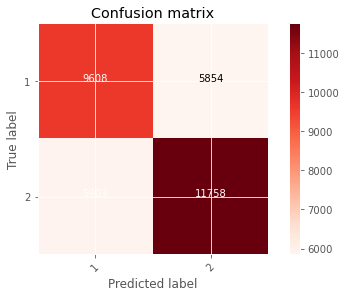

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = confusion_matrix(y_test, yhat, labels=['1','2'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2'],normalize= False,  title='Confusion matrix')

## Decision Tree

In [51]:
#selelcting Best Tree Depth
from sklearn.tree import DecisionTreeClassifier
start = time.time()
T=10
best=np.zeros(T)
for i in range(1,T+1):
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    Tree.fit(x_train,y_train)
    predTree = Tree.predict(x_test)
    print('Accuracy Score for Tree depth',i,':',accuracy_score(y_test,predTree))
print (predTree [0:5])
print (y_test [0:5])
end = time.time()
print("total Time Elasped: ",end - start," seconds")

Accuracy Score for Tree depth 1 : 0.5331944570238203
Accuracy Score for Tree depth 2 : 0.5698457265344322
Accuracy Score for Tree depth 3 : 0.641819883464662
Accuracy Score for Tree depth 4 : 0.646046553754189
Accuracy Score for Tree depth 5 : 0.6462880777707334
Accuracy Score for Tree depth 6 : 0.6468616973100263
Accuracy Score for Tree depth 7 : 0.6481598888989524
Accuracy Score for Tree depth 8 : 0.6493071279775383
Accuracy Score for Tree depth 9 : 0.6512997011140296
Accuracy Score for Tree depth 10 : 0.6500920810313076
['2' '2' '1' '2' '2']
['1' '2' '2' '1' '2']
total Time Elasped:  4.062061548233032  seconds


In [52]:
#creating tree based on best accuracy score for corresponding depth,i.e. 9
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 9)
Tree.fit(x_train,y_train)
predTree = Tree.predict(x_test)
print (predTree [0:5])
print (y_test [0:5])

['2' '2' '2' '2' '2']
['1' '2' '2' '1' '2']


In [53]:
#saving Scores
b1=accuracy_score(y_test,predTree)
b2=f1_score(y_test,predTree,average='weighted')

#### Plotting The Tree

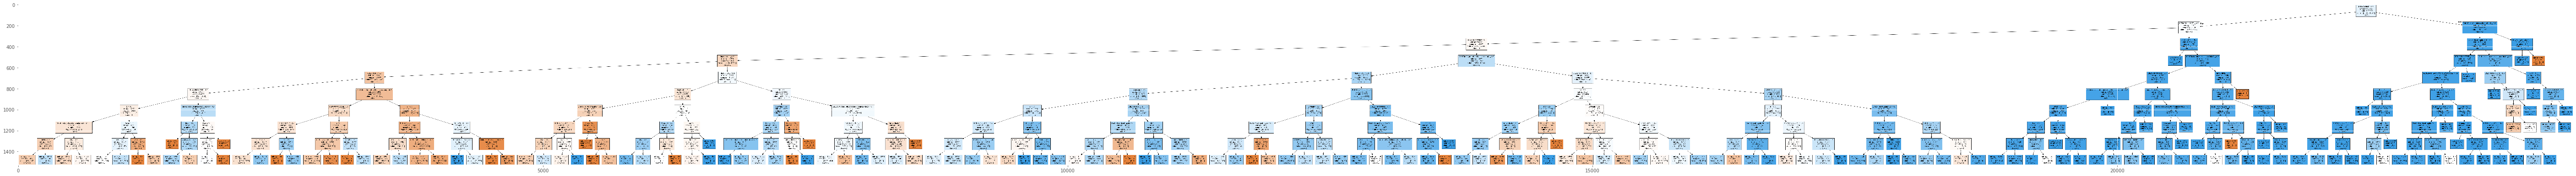

In [54]:
# The libaries needed to be installed
# after instaliing graphviz needed to be registered manually by adding path
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y
# installed graphwiz by downloading graphwiz.exe
# register garphviz using dot -c and dot -v in cmd running it as administrator
from six import StringIO
import graphviz
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn import datasets
from IPython.display import Image
dfi=dfK.copy()
dfi.drop('SEVERITYCODE',axis=1,inplace=True)
dot_data=StringIO()
filename="tree.png"
featurename=dfi.columns
targetNames=df['SEVERITYCODE'].unique().tolist()
out=tree.export_graphviz(Tree, feature_names=featurename, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

## K Nearest Neighbor Classifiaction

<ipython-input-55-e695f6326d40>:14: UserWarning: Legend does not support 'A' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Accuracy","+/- 3xstd")
<ipython-input-55-e695f6326d40>:14: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Accuracy","+/- 3xstd")
<ipython-input-55-e695f6326d40>:14: UserWarning: Legend does not support 'u' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Accuracy","+/- 3xstd")
<ipython-input-55-e695f6326d40>:14: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotli

total Time Elasped:  608.0774390697479  seconds


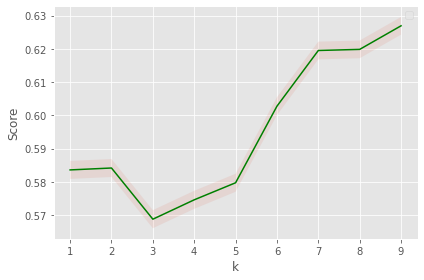

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
start = time.time()
Ks=10
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
for n in range(1,Ks):
    neigh=KNeighborsClassifier(n_neighbors=n).fit(x_train,y_train)
    yhat=neigh.predict(x_test)
    mean_acc[n-1]= accuracy_score(y_test,yhat)
    std_acc[n-1]=np.std(y_test==yhat)/np.sqrt(yhat.shape[0])
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc-1*std_acc,mean_acc+1*std_acc,alpha=0.10)
plt.legend("Accuracy","+/- 3xstd")
plt.xlabel("k")
plt.ylabel("Score")
plt.tight_layout()
end = time.time()
print("total Time Elasped: ",end - start," seconds")

In [56]:
#model Based on best K i.e.
neigh=KNeighborsClassifier(n_neighbors= 9).fit(x_train,y_train)
yhat1=neigh.predict(x_test)

In [57]:
#Saving Scores
c1=accuracy_score(y_test,yhat1)
c2=f1_score(y_test,yhat1,average='weighted')

## Support Vector Machine

In [58]:
from sklearn import svm
start = time.time()
clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
yhat2 = clf.predict(x_test)
end = time.time()
print("total Time Elasped: ",end - start," seconds")

total Time Elasped:  1103.1027443408966  seconds


In [59]:
d1=accuracy_score(y_test,yhat2)
d2=f1_score(y_test,yhat2,average='weighted')

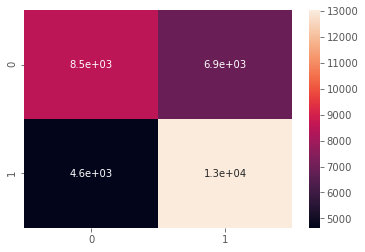

In [60]:
#We can Also create confusion matrix using the Heatmap function of Seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,yhat2),annot=True)

## Final Score Matrix

In [61]:
dataf=[['Logistic Regression',a1,a2,a3],['Decison Tree',b1,b2,'NA'],['KNN',c1,c2,'NA'],['SVM',d1,d2,'NA']]
ans_df=pd.DataFrame(dataf,columns=['Algorithm','Jaccard','F1-score','LogLoss'])
ans_df=ans_df.set_index(ans_df['Algorithm'])
ans_df.drop(['Algorithm'],axis=1,inplace=True)
ans_df

,Jaccard,F1-score,LogLoss
Algorithm,,,
Logistic Regression,0.644416,0.644726,0.608068
Decison Tree,0.651360,0.649095,NA
KNN,0.626936,0.626915,NA
SVM,0.650786,0.647455,NA


## Conclusion
#### Based on the following matrices we choose the Decision Tree as the best classifier for our model.